In [1]:
import sys
from functools import partial
sys.path.append("../../")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
import orbax.checkpoint

from sdebridge.sde import FourierGaussianKernelSDE
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge import plotting
from sdebridge.networks import ScoreUNet
from sdebridge.utils import create_train_state

2024-02-01 13:58:48.857844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 13:58:48.857878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 13:58:48.858832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 13:58:50.090500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

In [2]:
papilonidae_mean = jnp.load('../data/papilonidae_mean_pts.npy')
papilonidaes = jnp.load('../data/papilonidae_pts.npy')
ambrax = papilonidaes[2]
deiphobus = papilonidaes[5]
protenor = papilonidaes[6]
phestus = papilonidaes[10]
polytes = papilonidaes[23]

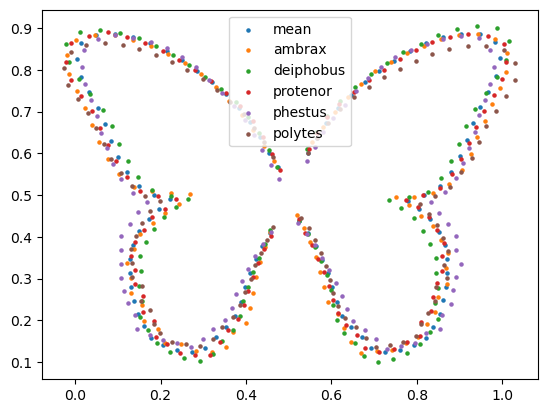

In [3]:
plt.scatter(papilonidae_mean[:, 0], papilonidae_mean[:, 1], s=5, label='mean')
plt.scatter(ambrax[:, 0], ambrax[:, 1], s=5, label='ambrax')
plt.scatter(deiphobus[:, 0], deiphobus[:, 1], s=5, label='deiphobus')
plt.scatter(protenor[:, 0], protenor[:, 1], s=5, label='protenor')
plt.scatter(phestus[:, 0], phestus[:, 1], s=5, label='phestus')
plt.scatter(polytes[:, 0], polytes[:, 1], s=5, label='polytes')
plt.legend()

In [4]:
n_bases = 16

sde_config_template = ConfigDict(
    {
        'init_S': None,
        'n_bases': n_bases,
        'n_grid': 64,
        'grid_range': [-1.0, 1.0],
        'alpha': 0.15,
        'sigma': 0.1,
        'T': 1.0,
        'N': 50,
        'dim': 2
    }
)

In [5]:
def compute_X_coeffs(initial_shape, target_shape=papilonidae_mean, n_bases=n_bases):
    n_pts = initial_shape.shape[0]
    X0_flatten = jnp.zeros((2*n_bases, ), dtype=jnp.complex64)
    diff = target_shape - initial_shape
    XT = jnp.fft.fftshift(jnp.fft.fft(diff, axis=0), axes=0)
    XT = XT[(n_pts-n_bases)//2:(n_pts+n_bases)//2, :]
    XT_flatten = jnp.concatenate([XT[:, 0], XT[:, 1]], axis=0)
    return X0_flatten, XT_flatten

def reconstruct_traj(Xs_flatten, initial_shape):
    n_pts = initial_shape.shape[0]
    Xs = jnp.stack(jnp.split(Xs_flatten, 2, axis=-1), axis=-1)
    n_bases = Xs.shape[-2]
    n_padding = (n_pts - n_bases) // 2
    Xs = jnp.pad(Xs, ((0, 0), (0, 0), (n_padding, n_padding), (0, 0)))
    Xs = jnp.fft.ifftshift(Xs, axes=-2)
    traj = jnp.fft.ifft(Xs, n=n_pts, axis=-2, norm='backward').real
    traj = traj + initial_shape[None, None, :, :]
    return traj

def load_ckpts(ckpt_path):
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    ckpt_dict = orbax_checkpointer.restore(ckpt_path)
    network_config = ckpt_dict["training_config"]["network"]
    new_state = create_train_state(
        model=ScoreUNet(**network_config),
        rng_key=jax.random.PRNGKey(0),
        input_shapes=((1, 2*2*n_bases), (1, 1)),
        learning_rate=0.01,
        warmup_steps=1,
        decay_steps=10
    )
    traget = {
        "state": new_state,
        "training_config": {},
    }
    ckpt = orbax_checkpointer.restore(ckpt_path, item=traget)
    return ckpt["state"]

def simulate_bridge(initial_shape, traget_shape=papilonidae_mean, n_bases=n_bases, score_p=None):
    sde_config = sde_config_template
    sde_config.init_S = initial_shape
    sde = FourierGaussianKernelSDE(sde_config)
    bridge = DiffusionBridge(sde)
    X0_flatten, XT_flatten = compute_X_coeffs(initial_shape, traget_shape, n_bases)
    Xs_flatten = bridge.simulate_backward_bridge(X0_flatten, XT_flatten, score_p=score_p, num_batches=4)["trajectories"]
    bwd_traj = reconstruct_traj(Xs_flatten, initial_shape)
    return bwd_traj

In [6]:
score_p_state = load_ckpts('/home/gefan/Projects/sdebridge/sdebridge/ckpts/score_p_16_bases_mean')

In [7]:
@partial(jax.jit)
def score_p(val, time):
    score_output = score_p_state.apply_fn(
        {"params": score_p_state.params, "batch_stats": score_p_state.batch_stats},
        x_complex=val,
        t=time,
        train=False
    )
    score_real, score_imag = jnp.split(score_output, 2, axis=-1)
    score = score_real + 1j * score_imag
    return score

In [11]:
bwd_traj_ambrax = simulate_bridge(ambrax, score_p=score_p)
bwd_traj_deiphobus = simulate_bridge(deiphobus, score_p=score_p)
bwd_traj_protenor = simulate_bridge(protenor, score_p=score_p)
bwd_traj_phestus = simulate_bridge(phestus, score_p=score_p)
bwd_traj_polytes = simulate_bridge(polytes, score_p=score_p)

In [12]:
print(bwd_traj_ambrax.shape)
print(bwd_traj_deiphobus.shape)
print(bwd_traj_protenor.shape)
print(bwd_traj_phestus.shape)
print(bwd_traj_polytes.shape)

(4, 50, 100, 2)
(4, 50, 100, 2)
(4, 50, 100, 2)
(4, 50, 100, 2)
(4, 50, 100, 2)


In [13]:
jnp.save('../data/papilonidae_traj/bwd_traj_ambrax.npy', bwd_traj_ambrax)
jnp.save('../data/papilonidae_traj/bwd_traj_deiphobus.npy', bwd_traj_deiphobus)
jnp.save('../data/papilonidae_traj/bwd_traj_protenor.npy', bwd_traj_protenor)
jnp.save('../data/papilonidae_traj/bwd_traj_phestus.npy', bwd_traj_phestus)
jnp.save('../data/papilonidae_traj/bwd_traj_polytes.npy', bwd_traj_polytes)